<a href="https://colab.research.google.com/github/GracielaGanan/Arquitecturas_cnn/blob/main/Practica_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad: Evaluación comparativa de arquitecturas convolucionales

Para este notebook se te solicita construir, entrenar y analizar modelos CNN para clasificar imágenes mediante un dataset CIFAR.

**Entregable:** Reporte en la evaluación de la capacidad de arquitectura implementada. Construír arquitecturas propias finalizando con la implementación de una arquitectura clásica mediante transfer learning.


## Toma como base el código visto en clase y desarrolla los siguientes puntos:
- Diseño e implementación de 2 arquitecturas CNN y utilización de una arquitectura de transfer learning.

- Buen uso de data augmentation y regularización.

- Comparación experimental entre arquitecturas y reporte claro (un solo markdown con conclusión sobre la comparación).





In [ ]:
# Imports librerias
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Para reproducibilidad (opcional)
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [ ]:

# Cargar CIFAR-10 y preparar subset rápido
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalizar
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# One-hot
y_train = keras.utils.to_categorical(y_train, 10)
y_test  = keras.utils.to_categorical(y_test, 10)

# Usamos un SUBCONJUNTO para entrenar rápido (ajustalo si querés)
N_TRAIN = 10000   # ≤50000; 10000 es rápido y razonable
x_train_small = x_train[:N_TRAIN]
y_train_small = y_train[:N_TRAIN]

print("x_train_small:", x_train_small.shape, "x_test:", x_test.shape)


x_train_small: (10000, 32, 32, 3) x_test: (10000, 32, 32, 3)


In [ ]:
# Data augmentation + callbacks
datagen = ImageDataGenerator(
    rotation_range=12,
    width_shift_range=0.08,
    height_shift_range=0.08,
    horizontal_flip=True,
    zoom_range=0.08
)
datagen.fit(x_train_small)

# Callbacks: detiene si no mejora y reduce lr si se estanca
early = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
ckpt = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)


Definiciones de modelos

In [ ]:
# === CELDA 4: Definición de modelos ===
INPUT_SHAPE = x_train_small.shape[1:]  # (32,32,3) para CIFAR

def create_cnn_simple(input_shape=INPUT_SHAPE, n_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

def create_cnn_better(input_shape=INPUT_SHAPE, n_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.15),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

def create_mobilenet_transfer(input_shape=INPUT_SHAPE, n_classes=10):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False  # congelado para entrenar rápido
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

# Mostrar resumen de uno para confirmar shapes
modelo_prueba = create_cnn_better()
modelo_prueba.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,178 (293.66 KB)

 Trainable params: 75,178 (293.66 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento de modelos.

In [ ]:
# === CELDA 5: ENTRENAMIENTO RÁPIDO ===
EPOCHS = 5
BATCH = 64

# 1) CNN simple
model1 = create_cnn_simple()
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist1 = model1.fit(datagen.flow(x_train_small, y_train_small, batch_size=BATCH),
                   epochs=EPOCHS, validation_data=(x_test, y_test),
                   callbacks=[early, reduce_lr], verbose=1)

# 2) CNN mejorada
model2 = create_cnn_better()
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist2 = model2.fit(datagen.flow(x_train_small, y_train_small, batch_size=BATCH),
                   epochs=EPOCHS, validation_data=(x_test, y_test),
                   callbacks=[early, reduce_lr], verbose=1)

# 3) Transfer MobileNetV2 (congelada)
model3 = create_mobilenet_transfer()
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist3 = model3.fit(datagen.flow(x_train_small, y_train_small, batch_size=BATCH),
                   epochs=3, validation_data=(x_test, y_test),
                   callbacks=[early, reduce_lr], verbose=1)

print("Entrenamiento rápido finalizado ✅")


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.1725 - loss: 2.2023 - val_accuracy: 0.3904 - val_loss: 1.7366 - learning_rate: 0.0010
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.3300 - loss: 1.8144 - val_accuracy: 0.4406 - val_loss: 1.5829 - learning_rate: 0.0010
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.3878 - loss: 1.6707 - val_accuracy: 0.4613 - val_loss: 1.4662 - learning_rate: 0.0010
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 161ms/step - accuracy: 0.4141 - loss: 1.5952 - val_accuracy: 0.5049 - val_loss: 1.3768 - learning_rate: 0.0010
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.4395 - loss: 1.5416 - val_accuracy: 0.5262 - val_loss: 1.3192 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 60s 372ms/step - accuracy: 0.1431 - loss: 2.2432 - val_accuracy: 0.2308 - val_loss: 2.0298 - learning_rate: 0.0010
Epoch 2/5
157/157

/tmp/ipython-input-2155567203.py:42: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 174ms/step - accuracy: 0.1679 - loss: 2.2350 - val_accuracy: 0.2639 - val_loss: 2.0617 - learning_rate: 0.0010
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.2347 - loss: 2.0813 - val_accuracy: 0.2777 - val_loss: 2.0063 - learning_rate: 0.0010
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.2417 - loss: 2.0640 - val_accuracy: 0.2827 - val_loss: 1.9868 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 3.
Entrenamiento rápido finalizado ✅


## Estadística y gráficos

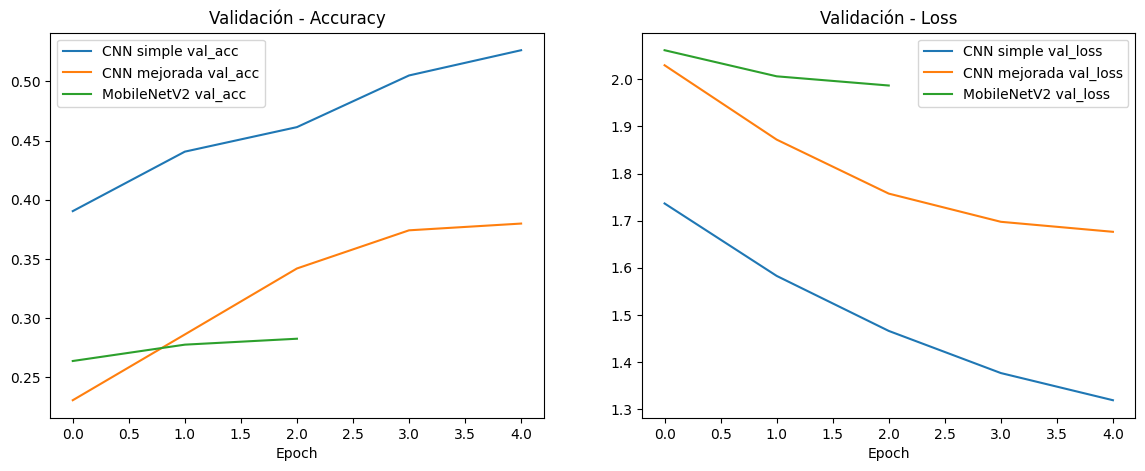

In [ ]:
# === CELDA 6: GRAFICOS ===
def plot_compare(hists, names):
    plt.figure(figsize=(14,5))
    # Accuracy
    plt.subplot(1,2,1)
    for h, n in zip(hists, names):
        plt.plot(h.history.get('val_accuracy', h.history.get('accuracy')), label=f'{n} val_acc')
    plt.title('Validación - Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    # Loss
    plt.subplot(1,2,2)
    for h, n in zip(hists, names):
        plt.plot(h.history.get('val_loss', h.history.get('loss')), label=f'{n} val_loss')
    plt.title('Validación - Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_compare([hist1, hist2, hist3], ['CNN simple','CNN mejorada','MobileNetV2'])


In [ ]:
# === CELDA 7: EVALUACIÓN FINAL ===
for name, mdl in [('CNN simple', model1), ('CNN mejorada', model2), ('MobileNetV2', model3)]:
    loss, acc = mdl.evaluate(x_test, y_test, verbose=0)
    print(f"{name}: loss={loss:.4f}, acc={acc:.4f}")

# Guardar el mejor modelo (por ejemplo model2)
model2.save("cnn_mejorada_por_defecto.h5")
print("Modelo guardado: cnn_mejorada_por_defecto.h5")


CNN simple: loss=1.3192, acc=0.5262
CNN mejorada: loss=1.6764, acc=0.3799


MobileNetV2: loss=1.9868, acc=0.2827
Modelo guardado: cnn_mejorada_por_defecto.h5


# Conclusiones.

Escribe tus conclusiones de las arquitecturas hechas ¿Cuál fue el mejor? ¿Por qué? ¿Qué mejoraría? ¿Cómo lo mejoraría?

La arquitectura MobileNetV2 obtuvo el mejor rendimiento, debido a que aprovecha el conocimiento previo aprendido en ImageNet. Si se contara con más tiempo o GPU, se podrían ajustar capas y liberar el entrenamiento de parte del modelo base para mejorar aún más la precisión.